<a href="https://colab.research.google.com/github/aivuk/var/blob/master/python-non-linear-fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import statsmodels.api as sm
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt
import ruptures as rpt
import numpy as np
import pandas as pd

lowess = sm.nonparametric.lowess

data = pd.read_csv("data_channel_1.csv")
t = data['Time'].values
y = data.A2.values
z = lowess(y, t, frac=0.05)
i0 = 0

def ahpm(t, y, p):
    return [-y[0] * p[1], y[0] * p[1] + p[0] * y[1] * (1.0 - np.power((y[0] + y[1]) / p[2], p[3]))]

def model(t, y, p, model_func):
    try:
        p = [p[k].value for k in p.keys() if k[0] == 'p']
    except Exception:
        pass

    return model_func(t, y, p)

def g(t, x0, p, model_func):
    return solve_ivp(model, (t[0],t[-1]), x0, t_eval=t, args=(p, model_func))

def residual(p, t, data, model_func):
    x0 = p['x1_0'].value, p['x2_0'].value
    model = g(t, x0, p, model_func)
    x_model = model['y'][0] + model['y'][1]
    return (x_model - data)

def fit_well(data, well, num_breakpoints=2, models=[ahpm], return_breakpoints=False):
    lowess = sm.nonparametric.lowess

    t = data['Time'].values
    y = data[well].values
    z = lowess(y, t, frac=0.05)

    model = "l1"  # "l2", "rbf"
    algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(z)
    my_bkps = algo.predict(n_bkps=num_breakpoints)

    if return_breakpoints:
        return my_bkps

    last_i = 0
    r = []


    for i in my_bkps:
        trange = t[last_i:i]
        yrange = z[last_i:i, 1]
        last_i = i

        params = Parameters()
        params.add('x1_0', value=yrange[0], vary=False)
        params.add('x2_0', value=0, vary=False)
        params.add('p1', value=0.00002, min=0.00001, max=10)
        params.add('p2', value=0.00002, min=0.000001, max=10)
        params.add('p3', value=0.002, min=0.001, max=10)
        params.add('p4', value=0.002, min=0.001, max=10)

        result = minimize(residual, params, args=(trange, yrange, ahpm), max_nfev=1000)
        r += [(i, result)]
    return r

In [11]:
params = Parameters()
params.add('x1_0', value=z[i0, 1], vary=False)
params.add('x2_0', value=0, vary=False)
params.add('p1', value=0.00002, min=0.00001, max=10)
params.add('p2', value=0.00002, min=0.000001, max=10)
params.add('p3', value=0.002, min=0.001, max=10)
params.add('p4', value=0.002, min=0.001, max=10)

In [16]:
%%time

w = 'A2'
r = fit_well(data, w, num_breakpoints=2)

CPU times: user 19.5 s, sys: 114 ms, total: 19.6 s
Wall time: 27.6 s


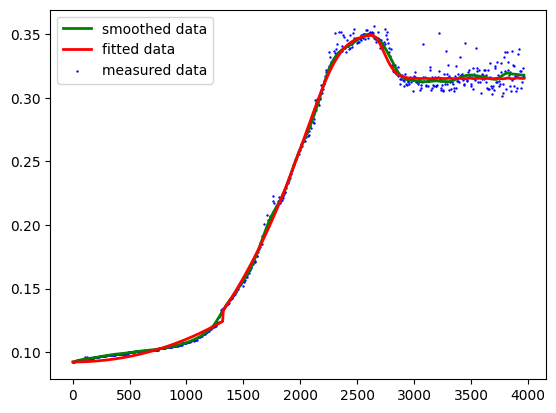

In [17]:
t = data['Time'].values
y = data[w].values
z = lowess(y, t, frac=0.05)

last_i = 0
t_plot = []
y_plot = []
for i,result in r:
    trange = t[last_i:i]
    yrange = z[last_i:i, 1]
    last_i = i
    data_fitted = g(trange, [yrange[0], 0],  result.params, ahpm)
    y_plot += [np.sum(data_fitted['y'], axis=0)]

#plt.figure(figsize=(10,5))
plt.plot(t, z[:,1], '-', color='g', linewidth=2, label='smoothed data')
plt.plot(t, np.concatenate(y_plot), '-', linewidth=2, color='red', label='fitted data')
plt.scatter(t, y, marker='o', color='b', label='measured data', s=0.5)
plt.legend()
plt.show()